## Generate image that maximizes CNN activations

This notebook shows how to generate input image that maximizes convolutional neural network activations. Random noise input is generated first and then very simle backpropagation algorithm is used to modify the image so that it maximizes the selected layer activations. 

The model used here is Keras pre-trained VGG16 with imagenet weights, but the same concept can be applied to any CNN model. 

The code takes few minutes to run on a PC without GPU. With GPU the results are available in few seconds. 

The code is developed by Mikko Kursula in 2018. The image generation algorithm concept is originally from Keras reference implementation, which I modified significantly for this notebook. 

MIT License. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K

%matplotlib inline

In [2]:
model = VGG16(weights='imagenet', include_top=True)

print('These are the model layers:')
for i in range(len(model.layers)):
    
    shape = model.layers[i].output_shape
    print(f'Layer index: {i}, name: {model.layers[i].name}, outut shape: {shape}')

These are the model layers:
Layer index: 0, name: input_1, outut shape: (None, 224, 224, 3)
Layer index: 1, name: block1_conv1, outut shape: (None, 224, 224, 64)
Layer index: 2, name: block1_conv2, outut shape: (None, 224, 224, 64)
Layer index: 3, name: block1_pool, outut shape: (None, 112, 112, 64)
Layer index: 4, name: block2_conv1, outut shape: (None, 112, 112, 128)
Layer index: 5, name: block2_conv2, outut shape: (None, 112, 112, 128)
Layer index: 6, name: block2_pool, outut shape: (None, 56, 56, 128)
Layer index: 7, name: block3_conv1, outut shape: (None, 56, 56, 256)
Layer index: 8, name: block3_conv2, outut shape: (None, 56, 56, 256)
Layer index: 9, name: block3_conv3, outut shape: (None, 56, 56, 256)
Layer index: 10, name: block3_pool, outut shape: (None, 28, 28, 256)
Layer index: 11, name: block4_conv1, outut shape: (None, 28, 28, 512)
Layer index: 12, name: block4_conv2, outut shape: (None, 28, 28, 512)
Layer index: 13, name: block4_conv3, outut shape: (None, 28, 28, 512)
Lay

## Generate the image

Loop: 0 loss value: 68.91676330566406
Loop: 20 loss value: 1280.58447265625
Loop: 40 loss value: 2383.401123046875
Loop: 60 loss value: 3601.337158203125
Loop: 80 loss value: 4866.0302734375
Loop: 100 loss value: 6152.728515625
Loop: 120 loss value: 7451.54541015625
Loop: 140 loss value: 8759.962890625
Loop: 160 loss value: 10074.822265625
Loop: 180 loss value: 11395.5361328125


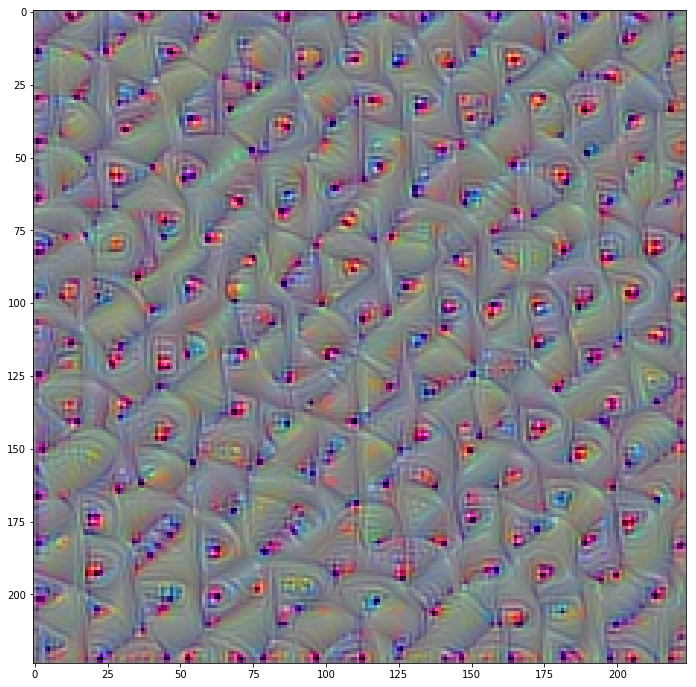

In [3]:
# Select parameters
img_shape = (224, 224, 3)
layer_index = 10  # the layer where the activations are maximized
filter_index = slice(10, 42) # select the filters
step_size = 1

# Setup a loss function that is the mean value of the selected layer outputs. 
# The value will be maximized by the algorithm. 
layer_output = model.layers[layer_index].output[:, :, :, filter_index]
loss = K.mean(layer_output)

# This is the placeholder for the input images
input_img = model.input

# Generate random noise input as a starting point. 
input_img_data = np.expand_dims(np.random.random(img_shape), axis=0) * 10
input_img_data = preprocess_input(input_img_data)

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

# Gradient computing
grads = K.gradients(loss, input_img)[0]
grads = normalize(grads)

# This function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# Generate the image
for i in range(200):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step_size
    
    # Plot intermediate results
    if i%20 == 0:
        print(f'Loop: {i} loss value: {loss_value}')

# Swap channels from bgr to rgb.
proc_img = np.zeros(input_img_data[0].shape)
proc_img[:, :, 0] = input_img_data[0, :, :, 2] 
proc_img[:, :, 1] = input_img_data[0, :, :, 1] 
proc_img[:, :, 2] = input_img_data[0, :, :, 0] 

# Scale values to [0, 255] range.
proc_img -= np.mean(proc_img)
proc_img /= np.std(proc_img) * 10
proc_img += .5
proc_img = np.clip(proc_img, 0, 1)
proc_img *= 255
proc_img = proc_img.astype(np.uint8)

# Plot the generated image
plt.figure(figsize=(12, 12))
plt.imshow(proc_img)
plt.show()